In [2]:
#importing packages
import os
import cv2
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras.applications import Xception
from tensorflow.keras import applications

2026-01-05 23:33:27.382970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 23:33:27.389660: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-05 23:33:27.594751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-05 23:33:28.646936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [3]:
def load_subdata(data,SIZE):
    X1 = []
    y1 = []
    size = SIZE
    lbl = 0
    dic = {}
    for folder_name in os.listdir(data):
        
        Label = lbl
        dic[folder_name] = Label  
        count_img = 0;

        for filename in os.listdir(data + '/' + folder_name):
            image = tf.keras.preprocessing.image.load_img(data +'/'+ folder_name + '/' + filename,color_mode='rgb', target_size=(size,size))
            arr = keras.preprocessing.image.img_to_array(image)
            X1.append(np.array([arr]))
            y1.append(Label) 
        lbl +=1   
         
    X1 = np.asarray(X1).reshape(len(X1),SIZE,SIZE,3).astype(np.int16)
    y1 = np.asarray(y1).astype(np.uint8)
    return X1,y1, dic


In [4]:
X, y, label_dic = load_subdata(r'../Dataset/',224)

In [5]:
from sklearn.utils import shuffle
X_new , y_new = shuffle(X, y, random_state=32)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_Test, y_train, y_Test = train_test_split(X_new , y_new, test_size=0.15, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_Test , y_Test, test_size=0.5, random_state=42)

In [7]:
print("Training Images Shape (x train shape) :", X_train.shape)
print("Label of training images (y train shape) :",y_train.shape)

print("Validation Images Shape (x val shape) :",X_val.shape)
print("Label of Validation images (y val shape) :",y_val.shape)

print("Test Images Shape (x val shape) :",X_test.shape)
print("Label of Test images (y val shape) :",y_test.shape)


Training Images Shape (x train shape) : (1752, 224, 224, 3)
Label of training images (y train shape) : (1752,)
Validation Images Shape (x val shape) : (155, 224, 224, 3)
Label of Validation images (y val shape) : (155,)
Test Images Shape (x val shape) : (155, 224, 224, 3)
Label of Test images (y val shape) : (155,)


In [8]:
y_trainHot = np.uint8(to_categorical(y_train, num_classes = 10))
y_testHot = np.uint8(to_categorical(y_test, num_classes = 10))
y_valHot = np.uint8(to_categorical(y_val, num_classes = 10))

In [9]:
print("One hot encoded labels")
print(y_trainHot.shape)
print(y_testHot.shape)
print(y_valHot.shape)


One hot encoded labels
(1752, 10)
(155, 10)
(155, 10)


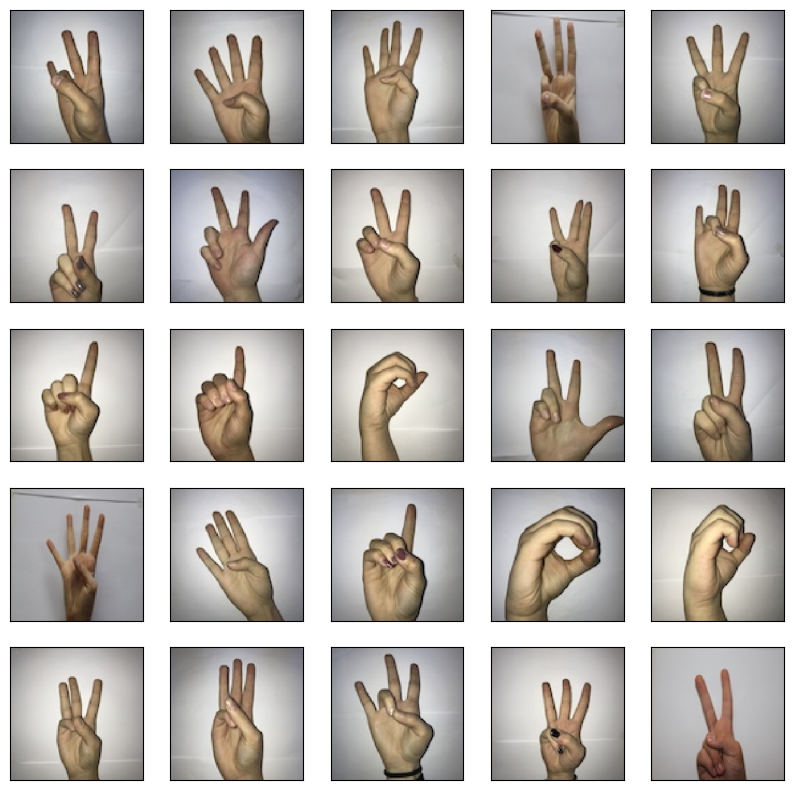

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    
plt.show()

In [11]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    y_test = y_testHot
    Y_pred = np.argmax(y_pred, axis=1)
    Y_Test = np.argmax(y_test, axis=1)
    
    class_names = list(label_dic.keys())
    print("Classification Report:")
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(Y_Test, Y_pred, target_names=class_names))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Y_Test, Y_pred)
    
    accuracy = recall_score(Y_Test, Y_pred, average=None)
    precision=precision_score(Y_Test,Y_pred,average=None)

    #class_names = class_names
    class_names = list(label_dic.keys())

    print("Confusion Matrix:")

    print(cf_matrix)
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    print("Accuracy for each class: ")
    
    for i in range(len(accuracy)):
        print(f"{class_names[i]}:  {format(accuracy[i]*100, '.2f')}%")


In [12]:
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(hist.history['accuracy'])
    ax1.plot(hist.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(hist.history['loss'])
    ax2.plot(hist.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()
    


# Xception-net

In [13]:
def Xception_Net():
    base_model =tf.keras.applications.Xception(input_shape = (224, 224, 3),include_top = False, classes=10) 
    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units=10, activation='softmax'))
    return model

In [14]:
xcep_model = Xception_Net()

E0000 00:00:1767630813.785357   13464 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767630813.789834   13464 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
xcep_model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy']) #when the learning rate was set to 0.01, the model showed a poor performance comparated to lr=0.0001
xcep_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     1,003,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,865,010 (83.41 MB)

 Trainable params: 21,810,482 (83.20 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
hist =xcep_model.fit(X_train, y_trainHot, epochs=10,batch_size=64,validation_data=(X_val,y_valHot))

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 295s 10s/step - accuracy: 0.6638 - loss: 1.0111 - val_accuracy: 0.2387 - val_loss: 2.6769
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 268s 10s/step - accuracy: 0.9720 - loss: 0.0928 - val_accuracy: 0.4516 - val_loss: 1.9456
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 263s 9s/step - accuracy: 0.9989 - loss: 0.0113 - val_accuracy: 0.7742 - val_loss: 0.6711
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 263s 9s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.8903 - val_loss: 0.2633
Epoch 5/10
20/28 ━━━━━━━━━━━━━━━━━━━━ 1:17 10s/step - accuracy: 1.0000 - loss: 0.0021

In [ ]:
plot_model(hist)

In [ ]:
model_Evaluate(xcep_model)

# Alex-net

AlexNet function: Defined a new function AlexNet() that constructs the classic AlexNet architecture from scratch using Keras layers. It includes:

Convolutional layers with ReLU activations.
Max pooling layers.
Fully connected layers with dropout.
Output layer with 10 units (for your 10 classes) and softmax activation.
Note: The original AlexNet used 227x227 inputs, but I adapted it for 224x224 to match your dataset's image size.

Model instantiation, compilation, training, and evaluation cells: Added cells to create the model (alex_model = AlexNet()), compile it with the same settings as Xception (categorical cross-entropy loss, Adam optimizer with learning rate 0.0001, accuracy metric), display the summary, train it for 10 epochs with batch size 64, plot the training history, and evaluate it using your existing plot_model and model_Evaluate functions.

In [ ]:
def AlexNet():
    model = Sequential()
    model.add(Conv2D(96, (11,11), strides=4, activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Conv2D(256, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Conv2D(384, (3,3), activation='relu'))
    model.add(Conv2D(384, (3,3), activation='relu'))
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [ ]:
alex_model = AlexNet()


In [ ]:
alex_model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy'])
alex_model.summary()

In [ ]:
hist_alex = alex_model.fit(X_train, y_trainHot, epochs=10,batch_size=64,validation_data=(X_val,y_valHot))

In [ ]:
plot_model(hist_alex)

In [ ]:
model_Evaluate(alex_model)